In [36]:
import os, sys, json, numpy as np, pandas as pd, json
import seaborn as sns
import xml.etree.ElementTree as ET

In [37]:
tree = ET.parse('data/selected_publications_mendeley_export.xml')

In [38]:
root = tree.getroot()

In [39]:
results = []
for record in root.findall('./records/record'):
    
    ref_type = record.find('ref-type')
    ref = ref_type.get('name')
    
    authors = record.findall('contributors/*/author')    
    authors = [a.text.strip().split(', ')[::-1] for a in authors]
    for i, author in enumerate(authors):
        first, last = author        
        authors[i] = tuple([*first.split(' '), last])
        
    authors = [{"name": a} for a in authors]
    
    
    title = record.find('*/title').text
    
    year = record.find('*/year')
    if year is not None:
        year = year.text
    
    month = record.find('*/pub-dates/date')
    if month is not None:
        month = month.text
        
    pages = record.find('pages')
    if pages is not None:
        pages = pages.text
        
    abstract = record.find('abstract')
    if abstract is not None:
        abstract = abstract.text
    
    publisher = record.find('publisher')
    if publisher is not None:
        publisher = publisher.text
    
    periodical = record.find('periodical/full-title')
    if periodical is not None:
        periodical = periodical.text
        
        
    if publisher == 'Nature Publishing Group':
        periodical = periodical.split(year)[0]
    
    keywords = [
        kw.text 
        for kw in record.findall('keywords/keyword') 
        if kw is not None
    ]
    
    urls = [
        url.text 
        for url in record.findall('urls/*/url')
        if url is not None
    ]
    urls = [{"href": url} for url in urls]
    
    volume = record.find('volumes')
    if volume is not None:
        volume = volume.text
    
    issue = record.find('issue')
    if issue is not None:
        issue = issue.text
    
    
    data = {
        "title": title,
        "type": ref,
        "authors": authors,
        "year": year,
        "month": month,
        "pages": pages,
        "abstract": abstract,
        "publisher": publisher,
        "periodical": periodical,
        "keywords": keywords,
        "urls": urls,
        "volume": volume,
        "issue": issue
    }
    results.append(data)

In [42]:
author_mapped = {}
author_parts = {}
for r in results:
    authors = r['authors']
    for author in authors:
        n = author['name']

        if n == ('D.', 'S.', 'Magruder'):
            mapped = ('Daniel', 'Sumner', 'Magruder')
        elif n == ('David', 'van Dijk') or n == ('David', 'Van', 'Dijk'):
            mapped = ('David', 'van', 'Dijk')
        elif n == ('Ronald', 'Coifman'):
            mapped = ('Ronald', 'R.', 'Coifman')
        elif n == ('Antonia', 'van', 'den', 'Elzen'):
            mapped = ('Antonia', 'van den', 'Elzen')
        elif n == ('Scott', 'Gigante'):
            mapped = ('Scott', 'A.', 'Gigante')
        elif n == ('Kincaid', 'Macdonald'):
            mapped = ('Kincaid', 'MacDonald')
        elif n == ('Jay', 'S', 'Stanley'):
            mapped = ('Jay', 'S.', 'Stanley')
        elif n == ('Alexander', 'Tong') or n == ('Alexander', 'Y', 'Tong'):
            mapped = ('Alexander', 'Y.', 'Tong')
        elif n == ('F.', 'Perry', 'Wilson'):
            mapped = ('Francis', 'Perry', 'Wilson')
            
        elif n == ('Michal', 'Gerasimiuk'):
            mapped = ('Michał', 'Gerasimiuk')
            
        else:
            mapped = n
            
        author_mapped[n] = mapped
            
            
        parts = {}                        
        for i, e in enumerate(mapped):
            if i == 0:
                parts['first'] =  e
                
            if i == 1 and len(n) == 2:
                parts['last'] =  e
                parts['middle'] =  None
                
            if i == 1 and len(n) == 3:
                parts['middle'] = e
                
            if i == 2 and len(n) == 3:
                parts['last'] =  e
        
        author_parts[mapped] = parts    
        
for r in results:
    authors = r['authors']
    for author in authors:
        n = author['name']
    authors = [
        {'name': author_mapped[author['name']]}
        for author in authors
    ]
    r['authors'] = authors

In [43]:
for r in results:
    r['selected'] = True    

In [130]:
# with open('data/selected_publications.json', 'w') as f:
#     json.dump(results, f)

## Map publications to members

In [138]:
with open('data/members_raw_24_02_2023.json', 'r') as f:
    member_data_raw = json.load(f)

In [139]:
member_data = member_data_raw.copy()

In [140]:
for member in member_data:
    name = member['name']

    preferred_name = name.split(' ')[0]
    if name == 'Dami Fasina':
        name = 'Oluwadamilola Fasina'
        preferred_name = 'Dami'
        
    elif name == 'Matt Amodio':
        name = 'Matthew Amodio'
        preferred_name = 'Matt'
            
        
    anames = list(author_parts.keys())
    found = False
    for aname in anames:
        if aname[0] in name and aname[-1] in name:
            found = True            
            break
            
    if found == False:
        print(name)
        parts = {}     
        parts['preferred'] = preferred_name
        for i, e in enumerate(name.split(' ')):
            if i == 0:
                parts['first'] =  e
                
            if i == 1 and len(name.split(' ')) == 2:
                parts['last'] =  e
                parts['middle'] =  None
                
            if i == 1 and len(name.split(' ')) == 3:
                parts['middle'] = e
                
            if i == 2 and len(name.split(' ')) == 3:
                parts['last'] =  e
        print(parts)
                
            
        
        
        
        member['name'] = parts
        member['publications'] = []
    else:
        pubs = []
        for result in results:
            for author in result['authors']:
                if author_mapped[author['name']] == aname:
                    pubs.append(result['title'])
        
        member['publications'] = pubs
        member['name'] = author_parts[aname]
        member['name']['preferred'] = preferred_name
    

Edward De Brouwer
{'preferred': 'Edward', 'first': 'Edward', 'last': 'De', 'middle': None}
Xingzhi Sun
{'preferred': 'Xingzhi', 'first': 'Xingzhi', 'last': 'Sun', 'middle': None}
Holly Steach
{'preferred': 'Holly', 'first': 'Holly', 'last': 'Steach', 'middle': None}
Chen Liu
{'preferred': 'Chen', 'first': 'Chen', 'last': 'Liu', 'middle': None}
Danqi Liao
{'preferred': 'Danqi', 'first': 'Danqi', 'last': 'Liao', 'middle': None}
Monica Munnangi
{'preferred': 'Monica', 'first': 'Monica', 'last': 'Munnangi', 'middle': None}
Sasha Safonova
{'preferred': 'Sasha', 'first': 'Sasha', 'last': 'Safonova', 'middle': None}
Andrew Benz
{'preferred': 'Andrew', 'first': 'Andrew', 'last': 'Benz', 'middle': None}
Katherine Du
{'preferred': 'Katherine', 'first': 'Katherine', 'last': 'Du', 'middle': None}
Tom Wallenstein
{'preferred': 'Tom', 'first': 'Tom', 'last': 'Wallenstein', 'middle': None}
Ngan Vu
{'preferred': 'Ngan', 'first': 'Ngan', 'last': 'Vu', 'middle': None}
Alexander Strzalkowski
{'preferred'

In [135]:
title_to_index = {}
for i, result in enumerate(results):
    title_to_index[result['title']] = i
    
member_to_index = {}
for i, member in enumerate(member_data):
    s = ''
    parts = member['name']
    
    s += parts['preferred']
    if parts['middle'] is not None:
        s += ' '
        s += parts['middle']
    s += ' '
    s += parts['last']
    
    member['name_str'] = s
    member_to_index[s] = i

In [136]:
with open('data/members.json', 'w') as f:
    json.dump(member_data, f)

## Make Selected Pubs graph

In [105]:
graph_data = []
for i, member in enumerate(member_data_raw):
    
    for j, other in enumerate(member_data_raw):
        if i == j:
            continue
        
        ipubs = member['publications']
        for _, ipub in enumerate(ipubs):    
            
            jpubs = other['publications']
            if ipub in jpubs:                           
                graph_data.append({
                    'author_a': member['name_str'],
                    'author_a_index': i,
                    'author_b': other['name_str'],
                    'author_b_index': j,
                    'publication_title': ipub,
                    'publication_index': title_to_index[ipub]
                })

In [114]:
graph_nodes = []
for member in member_data_raw:
    graph_nodes.append({
        'author_name': member['name_str'],
        'author_name_parts': member['name'],        
    })    

In [115]:
# with open('data/selected_publications_graph.json', 'w') as f:
#     json.dump({'nodes': graph_nodes, 'links': graph_data}, f)

In [106]:
df_agg = pd.DataFrame(graph_data)

In [108]:
adj_mat = np.zeros((len(member_data_raw), len(member_data_raw)))
for _, record in df_agg.iterrows():
    i = record.author_a_index
    j = record.author_b_index
    adj_mat[i, j] = record.publication_index

<AxesSubplot:>

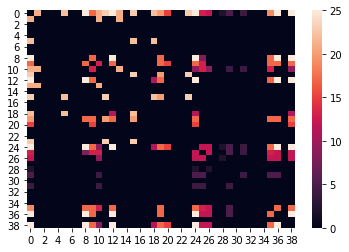

In [109]:
sns.heatmap(adj_mat)